<a href="https://colab.research.google.com/github/Gedeon-m-gedus/Image_Processing/blob/master/21_Unet_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import time
from tqdm import tqdm


from pathlib import Path

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

import shutil

import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import albumentations
import torchvision 
from torchvision import transforms, models

import random
from skimage import io,transform
from PIL import Image

import warnings 

warnings.filterwarnings("ignore")

In [43]:
!pip install imagecodecs

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
ROOT = Path("/content/drive/MyDrive/IRCAD")
#ROOT = Path("/content/drive/Shareddrives/IRCAD")

train_image_path = ROOT / "train"
train_mask_path = ROOT / "train"
test_image_path = ROOT / "test"

ALL_MASKS =[os.path.join(train_mask_path,i) for i in os.listdir(train_mask_path) if "mask" in i]
len(ALL_MASKS)
ALL_IMAGES = [i.replace("_mask","") for i in ALL_MASKS]
len(ALL_IMAGES)

In [22]:

df = pd.DataFrame({"Image":ALL_IMAGES,"Mask":ALL_MASKS})
df

,Image,Mask
0,/content/drive/MyDrive/IRCAD/train/6_21.tif,/content/drive/MyDrive/IRCAD/train/6_21_mask.tif
1,/content/drive/MyDrive/IRCAD/train/5_97.tif,/content/drive/MyDrive/IRCAD/train/5_97_mask.tif
2,/content/drive/MyDrive/IRCAD/train/5_82.tif,/content/drive/MyDrive/IRCAD/train/5_82_mask.tif
3,/content/drive/MyDrive/IRCAD/train/5_77.tif,/content/drive/MyDrive/IRCAD/train/5_77_mask.tif
4,/content/drive/MyDrive/IRCAD/train/5_87.tif,/content/drive/MyDrive/IRCAD/train/5_87_mask.tif
...,...,...
5630,/content/drive/MyDrive/IRCAD/train/11_60.tif,/content/drive/MyDrive/IRCAD/train/11_60_mask.tif
5631,/content/drive/MyDrive/IRCAD/train/11_55.tif,/content/drive/MyDrive/IRCAD/train/11_55_mask.tif
5632,/content/drive/MyDrive/IRCAD/train/11_18.tif,/content/drive/MyDrive/IRCAD/train/11_18_mask.tif
5633,/content/drive/MyDrive/IRCAD/train/11_14.tif,/content/drive/MyDrive/IRCAD/train/11_14_mask.tif


In [23]:
from sklearn import model_selection

def makesplits(df,k):
    df["kfold"] = -1
    df = df.sample(frac=1).reset_index(drop=True)
    kf = model_selection.KFold(n_splits=k)

    for f,(t_,v_) in enumerate(kf.split(df)):
        df.loc[v_,"kfold"] = f
    return df
    
kfold_ = makesplits(df,5)
kfold_.to_csv("Kfolds.csv",index=None)

In [24]:
## DATA AUGMENTATION
def trainaugs():
    transform =  [
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip()
            ]
    return albumentations.Compose(transform)

def valaugs():
    transform = [
                albumentations.HorizontalFlip(),
                albumentations.VerticalFlip()
            ]
    return albumentations.Compose(transform)

In [25]:
class NerveDataset(Dataset):
    def __init__(self,imagespath,maskspath,augment=None):
        self.imagespath = imagespath
        self.maskspath = maskspath
        self.augment = augment
        
    def __len__(self):
        return len(self.imagespath)
    
    def __getitem__(self,idx):
        image = self.imagespath[idx]
        mask = self.maskspath[idx]
        image = io.imread(image)
        mask = io.imread(mask)
        image = transform.resize(image=image,output_shape=(256,256,3)) # (256,256,3)
        image = image/255.0
        mask = transform.resize(mask,(256,256))  # (256,256,1)
        mask = mask / 255.0
        
        if self.augment:
            sample = self.augment(image=image, mask=mask)
            image,mask = sample['image'],sample['mask']
            
        image = image.transpose((2, 0, 1)) # (3,256,256)
        mask = np.expand_dims(mask,axis=-1).transpose((2,0,1)) # (1,256,256)
            
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
            
        return image,mask

In [26]:
from torchvision import transforms, utils
from torch import nn

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [27]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding,bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
    
class StackDecoder(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_tensor):
            _, channels, height, width = down_tensor.size()  
            x = F.upsample(x, size=(height, width), mode='bilinear')
            x = torch.cat([x, down_tensor], 1)  #combining channels of  input from encoder and upsampling input
            x = self.block(x)
            return x
        
        
class Unet256(nn.Module):
    def __init__(self,input_shape):
        super(Unet256,self).__init__()
        
        channel,height,width = input_shape
        
        self.down1 = StackEncoder(channel,12,kernel_size=(3,3))  #256
        self.down2 = StackEncoder(12,24,kernel_size=(3,3))  # 128
        self.down3 = StackEncoder(24,46,kernel_size=(3,3))  # 64
        self.down4 = StackEncoder(46,64,kernel_size=(3,3))  # 32
        self.down5 = StackEncoder(64,128,kernel_size=(3,3))  #16
        
        self.center = ConvBlock(128,128,kernel_size=(3,3),padding=1) #16
        self.up5 = StackDecoder(128,128,64,kernel_size=(3,3))  #32
        self.up4 = StackDecoder(64,64,46,kernel_size=(3,3)) #64
        self.up3 = StackDecoder(46,46,24,kernel_size=(3,3))
        self.up2 = StackDecoder(24,24,12,kernel_size=(3,3))
        self.up1 = StackDecoder(12,12,12,kernel_size=(3,3))
        self.conv = Conv2d(12,1,kernel_size=(1,1),bias=True)
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        down3,out = self.down3(out)
        down4,out = self.down4(out)
        down5,out = self.down5(out)
        
        
        out = self.center(out)
        
        up5 = self.up5(out,down5)
        up4 = self.up4(up5,down4)
        up3 = self.up3(up4,down3)
        up2 = self.up2(up3,down2)
        up1 = self.up1(up2,down1)
        
        out = self.conv(up1)


        return out

In [28]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
    

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100

    
    
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score

In [46]:
def train_model(fold):
    train_loss = []
    train_iou = []
    train_dice = []
    val_loss = []
    val_iou = []
    val_dice = []
    epochs = 2
    train_bs= 8
    val_bs = 4
    
    FILE = f"./savedmodels/model_Fold_{fold}.pth"
    
    if not os.path.exists("./savedmodels"):
        os.mkdir("savedmodels")
        
    print(f"*"*20,"FOLD",fold, "*"*20)
    df = pd.read_csv("Kfolds.csv")
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_val = df[df.kfold == fold].reset_index(drop=True)
    
    traindata = NerveDataset(imagespath = df_train['Image'].tolist(),
                            maskspath = df_train['Mask'].tolist(),
                        augment=trainaugs())

    validationdata = NerveDataset(imagespath = df_val['Image'].tolist(),
                                maskspath = df_val['Mask'].tolist(),augment=valaugs())

    trainloader = DataLoader(traindata,batch_size = train_bs,shuffle=True)
    valloader = DataLoader(validationdata,batch_size=val_bs,shuffle=False)
    
    model = Unet256((3,256,256)).to(device)
    iou_ = IoU()
    criterion = DiceBCELoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        start_time = time.time()
        running_train_loss = []
        running_train_iou = []

        tk_train = tqdm(trainloader,total = len(trainloader))
        for image,mask in tk_train: 
                image = image.to(device,dtype=torch.float)
                mask = mask.to(device,dtype=torch.float)

                pred_mask = model.forward(image) # forward propogation
                loss = criterion(pred_mask,mask)
                iou = iou_(pred_mask,mask)
                optimizer.zero_grad() # setting gradient to zero
                loss.backward()
                optimizer.step()
                running_train_loss.append(loss.item())
                running_train_iou.append(iou.item())
        else:           
            running_val_loss = []
            running_val_iou = []
            
            with torch.no_grad():
                tk_val = tqdm(valloader,total = len(valloader))
                for image,mask in tk_val:
                        image = image.to(device,dtype=torch.float)
                        mask = mask.to(device,dtype=torch.float)                            
                        pred_mask = model.forward(image)
                        loss = criterion(pred_mask,mask)
                        iou = iou_(pred_mask,mask)
                        running_val_loss.append(loss.item())
                        running_val_iou.append(iou.item())

        epoch_train_loss = np.mean(running_train_loss) 
        print(f'Fold: {fold} <---> Epoch: {epoch + 1} <---> Train DiceBCELoss: {epoch_train_loss}')                       
        train_loss.append(epoch_train_loss)
        
        epoch_val_loss = np.mean(running_val_loss)
        print(f'Fold: {fold} <---> Epoch: {epoch + 1} <---> Validation DiceBCELoss: {epoch_val_loss}')                                
        val_loss.append(epoch_val_loss)
        
        epoch_train_iou = np.mean(running_train_iou)
        print(f'Fold: {fold} <---> Epoch: {epoch + 1} <---> Train IOU: {epoch_train_iou}')                                
        train_iou.append(epoch_train_iou)
        
        epoch_val_iou = np.mean(running_val_iou)
        print(f'Fold: {fold} <---> Epoch: {epoch + 1} <---> Validation IOU: {epoch_val_iou}')                                
        val_iou.append(epoch_val_iou)
        

        time_elapsed = time.time() - start_time
        print('Fold {}: Time Taken: {:.0f}m {:.0f}s'.format(fold,time_elapsed // 60, time_elapsed % 60))
        
    torch.save(model.state_dict(), FILE)
        
    return train_loss, val_loss,train_iou,val_iou

In [48]:
train_model(0)

In [45]:
# !pip list

In [ ]:

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = str(image_path)
    # image=cv2.imread(image_path, 1)
    # image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # mask=cv2.imread(masks[index])

    #image = Image.open(image_path)
    image = gif_imread(image_path,plugin='pil')
    #image = np.reshape(np.asarray([image, image, image]), (image.shape[0], image.shape[1], 3))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #image = image.transpose((0, 1, 2)).astype(np.float32)
    print(image.shape)
    print(image.astype)
    mask = gif_imread(masks[index],plugin='pil')
    print(mask.shape)
    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]

        mask = temp["mask"]
        print(mask.shape)
        print(image.shape)

    show_examples(name, image, mask)

def show_random(images, masks, transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

(420, 580, 3)
<built-in method astype of numpy.ndarray object at 0x7f92ce081ee0>
(420, 580)


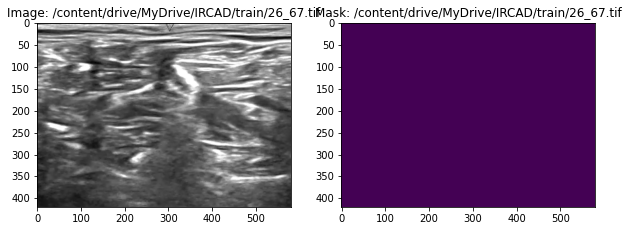

In [ ]:
show_random(ALL_IMAGES, ALL_MASKS)

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = gif_imread(image_path,plugin='pil')
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
 
        result = {"image": image}
        
        if self.masks is not None:
            mask = gif_imread(self.masks[idx],plugin='pil')
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)

        return result

In [ ]:
def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, interpolation = Image.BILINEAR, p=1)]


def hard_transforms():
    result = [
      albu.RandomRotate90(),
      albu.Cutout(),
      albu.GaussNoise(), 
      albu.HorizontalFlip(p=0.5),
    ]

    return result
  

def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )])

    rescale = albu.Compose([albu.Rfrom sklearn import model_selection

def makesplits(df,k):
    df["kfold"] = -1
    df = df.sample(frac=1).reset_index(drop=True)
    kf = model_selection.KFold(n_splits=k)

    for f,(t_,v_) in enumerate(kf.split(df)):
        df.loc[v_,"kfold"] = f
    return dfesize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result


train_transforms = compose([resize_transforms(), hard_transforms(), post_transforms()])
valid_transforms = compose([pre_transforms(), post_transforms()])

#show_transforms = compose([resize_transforms(), post_transforms()])


In [ ]:
def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    #Data loaders
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

batch_size = 32   
loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=42,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

In [ ]:
# def dice_loss(pred, target):
#     """Cacluate dice loss 
#     Parameters
#     ----------
#         pred:
#             predictions from the model
#         target:
#             ground truth label
#     """
                                                                         
#     smooth = 1.                                                          
                                                                         
#     p_flat = pred.contiguous().view(-1)                                   
#     t_flat = target.contiguous().view(-1)                                 
#     intersection = (p_flat * t_flat).sum()                                 
                                                                         
#     a_sum = torch.sum(p_flat * p_flat)                                     
#     b_sum = torch.sum(t_flat * t_flat)                                     
                                                                         
#     return 1 - ((2. * intersection + smooth) / (a_sum + b_sum + smooth) )





class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
    

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100

    
    
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
        
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
#hyperparameters
learning_rate = 0.01,
epochs = 5,
batch_size = 32,
n_channels = 3,
n_classes = 1,
net = UNet(n_channels=3, n_classes=1, bilinear=True)
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
#criterion = nn.BCEWithLogitsLoss()


from catalyst.dl import SupervisedRunner

num_epochs = 20
logdir = "/content/drive/MyDrive/IRCAD/logs/segmentation"

#device = utils.get_device()
print(f"device: {device}")

fp16_params = None

print(f"FP16 params: {fp16_params}")


# by default SupervisedRunner uses "features" and "targets",
# in our case we get "image" and "mask" keys in dataset __getitem__
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

device: cuda
FP16 params: None


In [ ]:
epochs = 5
train_loader = loaders["train"]
valid_loader = loaders["valid"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from catalyst.dl import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback
from catalyst.contrib.callbacks import DrawMasksCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
    # visualization
    DrawMasksCallback(output_key='logits',
                      input_image_key='image',
                      input_mask_key='mask',
                      summary_step=50
    )
]
runner.train(
  model=net,
  criterion=criterion,
  optimizer=optimizer,
  scheduler=scheduler,
  # our dataloaders
  loaders=loaders,
  # We can specify the callbacks list for the experiment;
  callbacks=callbacks,
  # path to save logs
  logdir=logdir,
  num_epochs=num_epochs,
  # save our best checkpoint by dice metric
  main_metric="dice",
  # IoU needs to be maximized.
  minimize_metric=True,
  # for FP16. It uses the variable from the very first cell
  fp16=fp16_params,
  # prints train logs    
  verbose=True,

)

1/20 * Epoch (train):  83% 116/140 [17:15<01:58,  4.96s/it, dice=0.121, iou=0.064, loss=1.899, loss_bce=0.105, loss_dice=0.879, loss_iou=0.936]

In [ ]:
# Catalyst
!pip install catalyst==20.12

# for augmentations
!pip install albumentations==0.4.3

# for pretrained segmentation models for PyTorch
!pip install segmentation-models-pytorch==0.1.0

# for TTA
!pip install ttach==0.0.2

# for tensorboard
#!pip install tensorflow